In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import torch
import torch.nn.functional as F
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
from memit import compute_z, get_target_new_avg_prob, get_context_templates, MEMITHyperParams
from memit.compute_z import get_module_input_output_at_words
from util import nethook
from experiments.py.eval_utils_counterfact import compute_rewrite_quality_counterfact
import json
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
from dsets import (
    AttributeSnippets,
    CounterFactDataset,
    MENDQADataset,
    MultiCounterFactDataset,
    get_tfidf_vectorizer,
    KnownsDataset,
)
from tqdm import tqdm

from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 20

/home/hello/miniconda3/envs/swea/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Hidden Representation Analysis

In [3]:
from sklearn.preprocessing import MinMaxScaler
def create_scatter_density_plot(x_pre, y_pre, x_post, y_post, post_color = 'salmon'):
    # 创建画布和网格
    fig = plt.figure(figsize=(8, 6))
    gs = GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],hspace=0.01,wspace=0.01)
    
    # 创建三个子图
    ax_scatter = fig.add_subplot(gs[1, 0])  # 主散点图
    ax_top = fig.add_subplot(gs[0, 0])  # 上方密度图
    ax_right = fig.add_subplot(gs[1, 1])  # 右侧密度图
    
    # 绘制散点图
    ax_scatter.scatter(x_pre, y_pre, c='skyblue', alpha=0.5, s=10, label='Pre-edited')
    ax_scatter.scatter(x_post, y_post, c=post_color, alpha=0.5, s=10, label='Post-edited')
    
    # 计算和绘制椭圆轮廓
    def plot_confidence_ellipse(x, y, ax, color):
        # 获取数据范围
        x_min, x_max = min(x), max(x)
        y_min, y_max = min(y), max(y)

        # 椭圆的中心为数据的平均值
        center_x, center_y = np.mean(x), np.mean(y)

        # 宽度和高度覆盖数据范围
        width = (x_max - x_min) * 1.1  # 加一些余量
        height = (y_max - y_min) * 1.1

        # 创建椭圆
        from matplotlib.patches import Ellipse
        ellip = Ellipse(
            xy=(center_x, center_y),
            width=width,
            height=height,
            angle=0,  # 不旋转
            fill=False,
            linestyle="--",
            color=color
        )
        ax.add_patch(ellip)

    
    plot_confidence_ellipse(x_pre, y_pre, ax_scatter, 'skyblue')
    plot_confidence_ellipse(x_post, y_post, ax_scatter, post_color)
    
    # 绘制边缘密度分布
    sns.kdeplot(data=x_pre, ax=ax_top, color='skyblue', fill=True, alpha=0.5)
    sns.kdeplot(data=x_post, ax=ax_top, color=post_color, fill=True, alpha=0.5)
    
    sns.kdeplot(data=y_pre, ax=ax_right, vertical=True, color='skyblue', fill=True, alpha=0.5)
    sns.kdeplot(data=y_post, ax=ax_right, vertical=True, color=post_color, fill=True, alpha=0.5)
    
    # 设置标题和标签

    ax_scatter.legend()
    ax_scatter.grid(True, alpha=0.3)
    
    # 设置轴范围

    
    # 移除不需要的刻度和标签
    ax_top.set_xticks([])  # 删除 ax_top 的 x 轴刻度
    ax_top.set_yticks([])  # 删除 ax_top 的 y 轴刻度

    ax_right.set_xticks([])  # 删除 ax_right 的 x 轴刻度
    ax_right.set_yticks([])  # 删除 ax_right 的 y 轴刻度

    
    # 调整布局
    plt.tight_layout()
    return fig

def tsne_data(data):
    # 转置数据，使得每一行表示一个样本
    data_T = data.T  # 1209 x 4096

    # 进行t-SNE降维，目标维度设为2（二维）
    tsne = TSNE(n_components=2, random_state=42,perplexity=30)
    data_tsne = tsne.fit_transform(data_T)

    return data_tsne[:, 0], data_tsne[:, 1]


/home/hello/miniconda3/envs/swea/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hello/miniconda3/envs/swea/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/hello/miniconda3/envs/swea/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hello/miniconda3/envs/swea/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_2512357/1135032657.py:50: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.


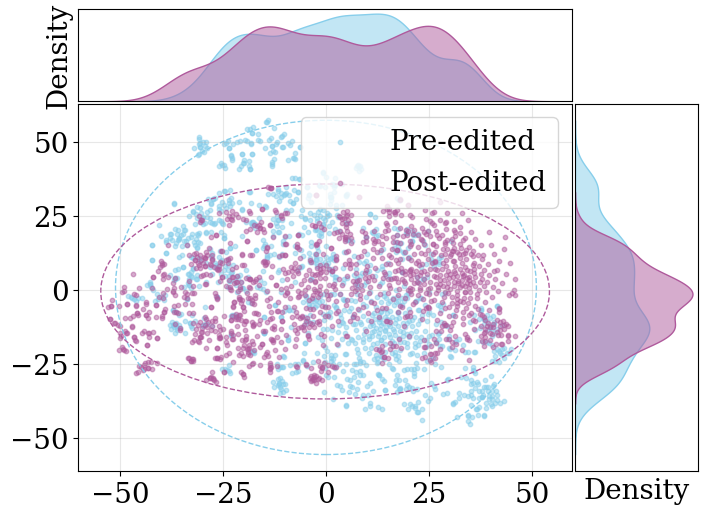

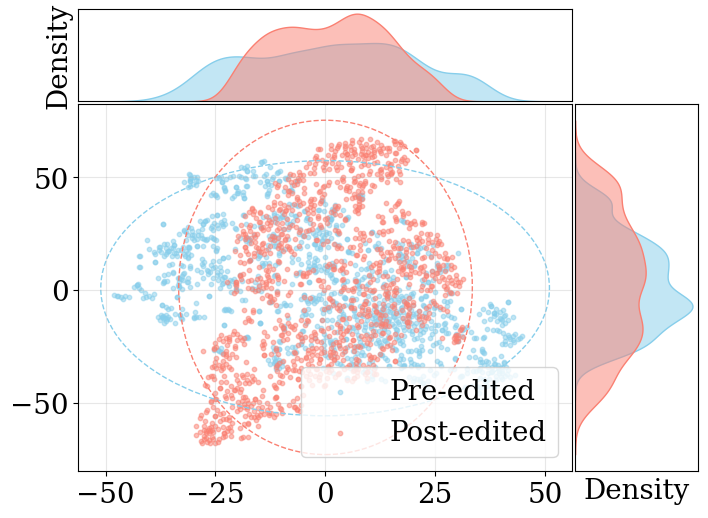

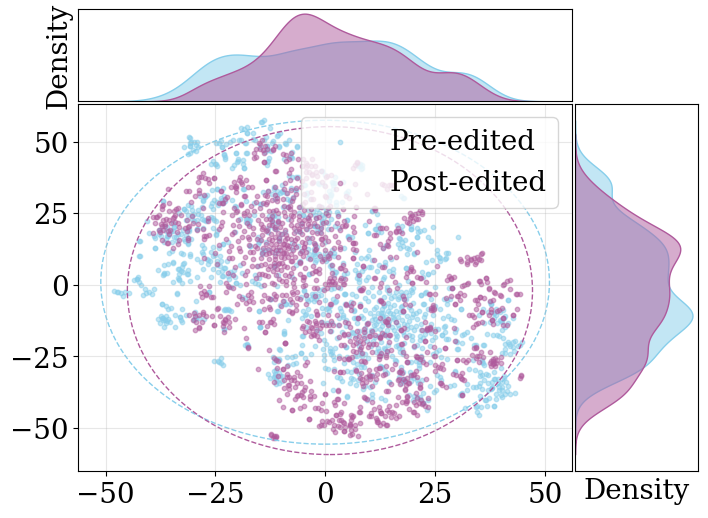

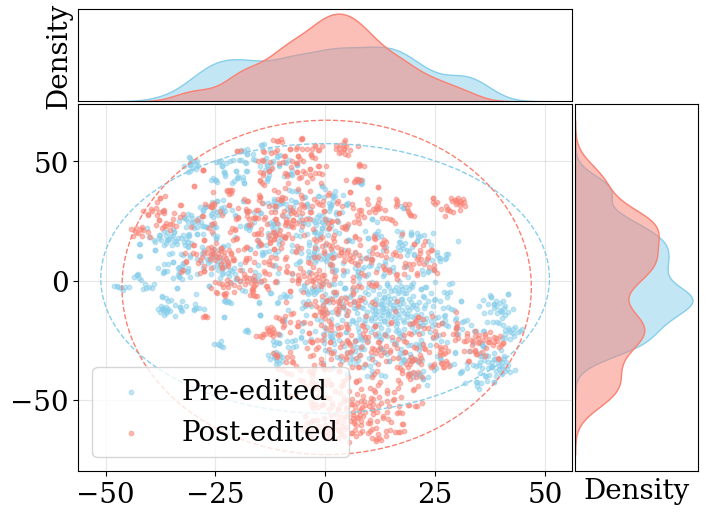

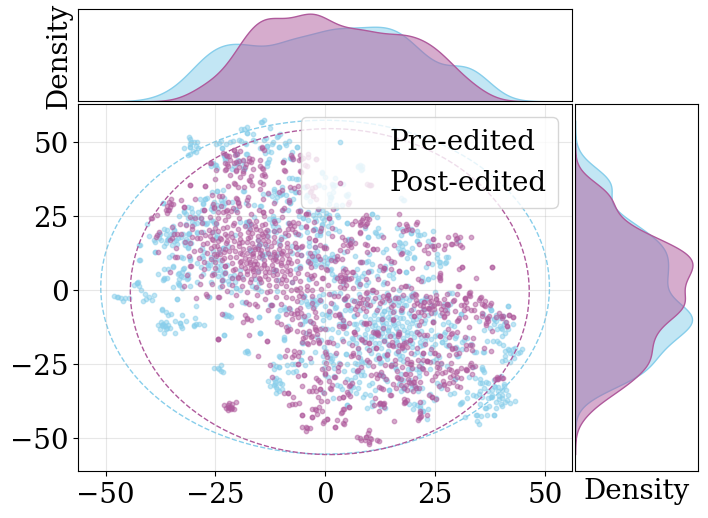

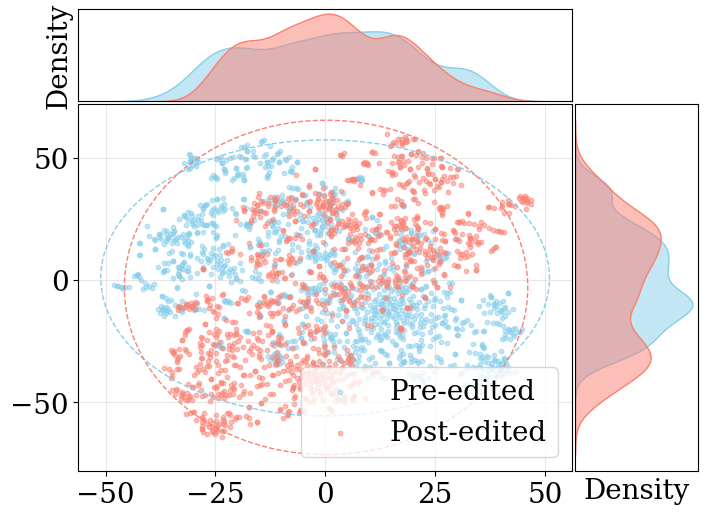

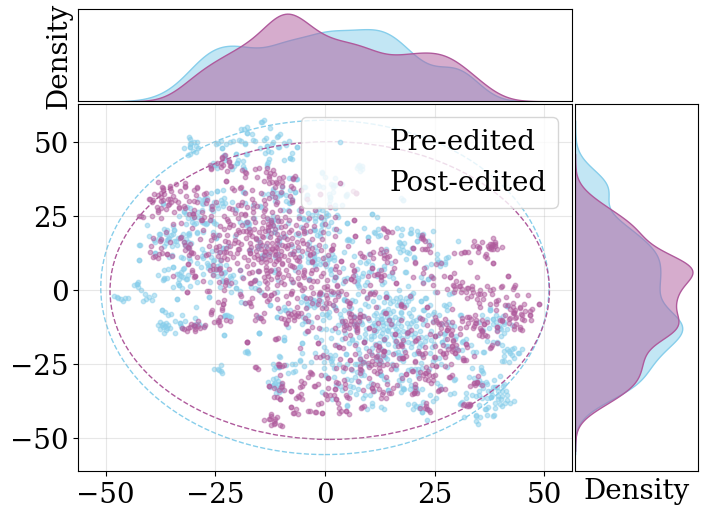

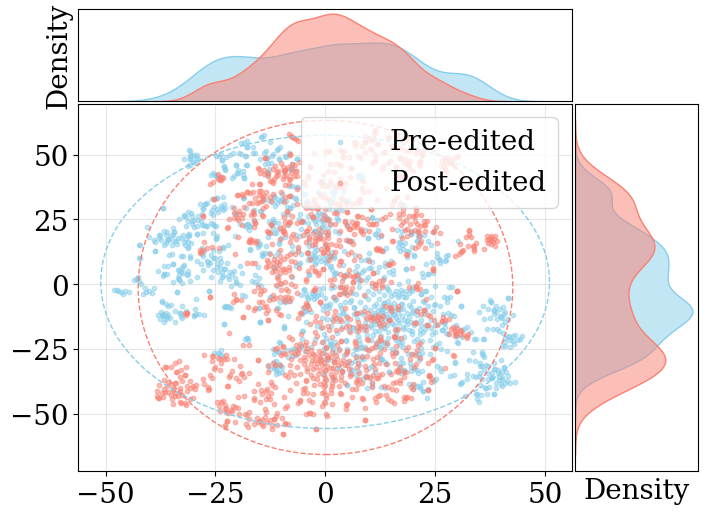

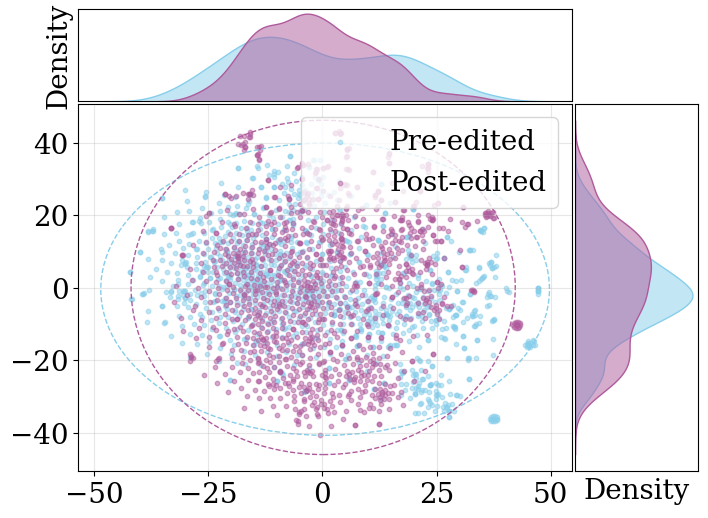

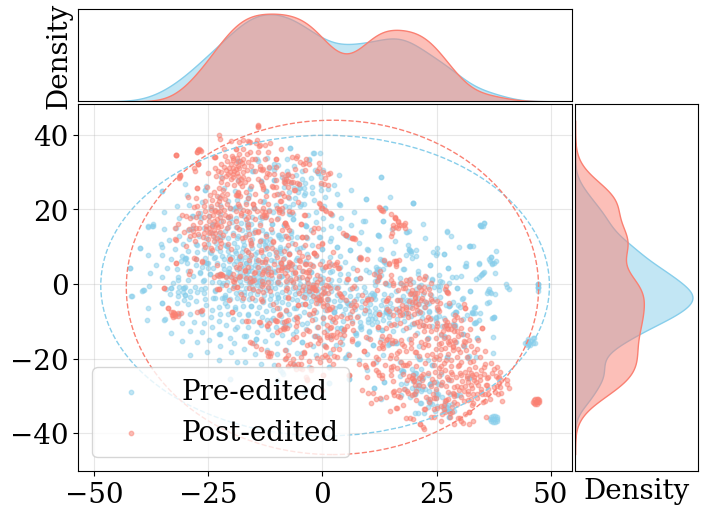

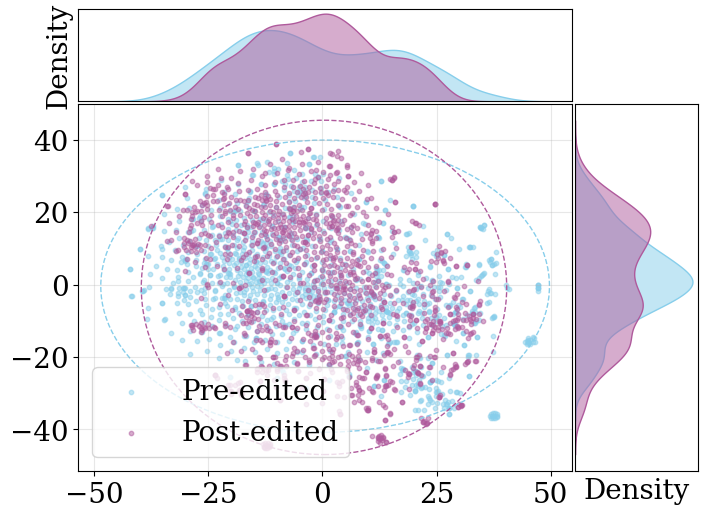

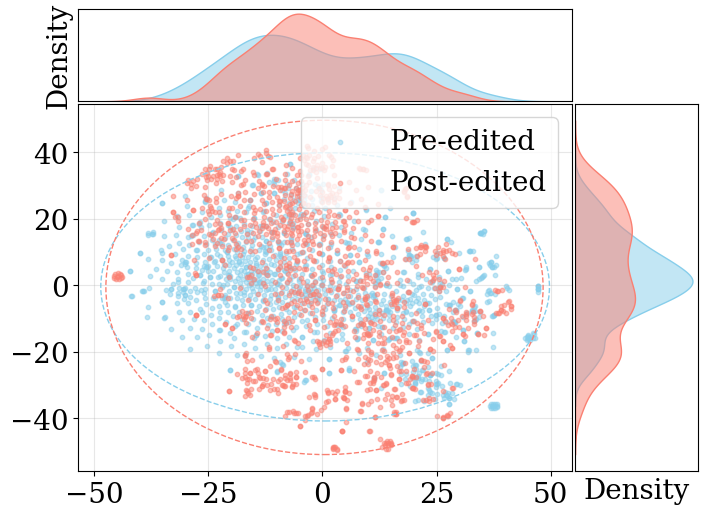

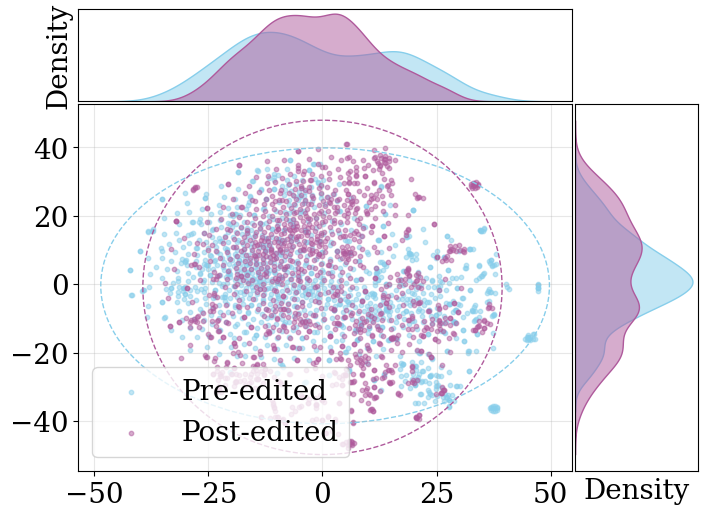

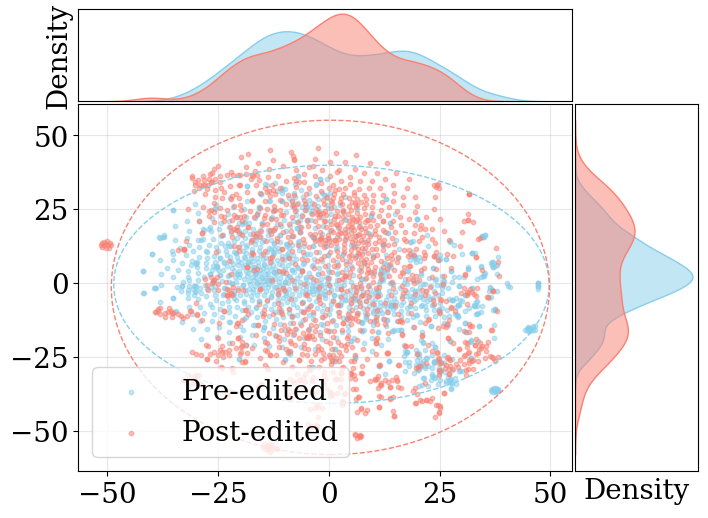

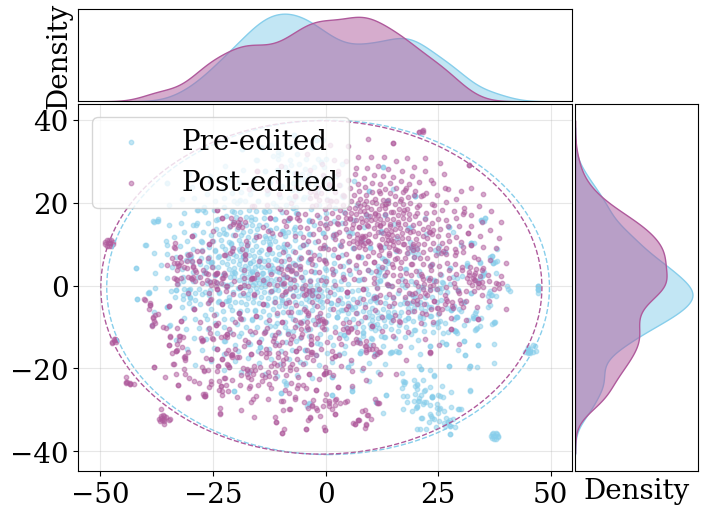

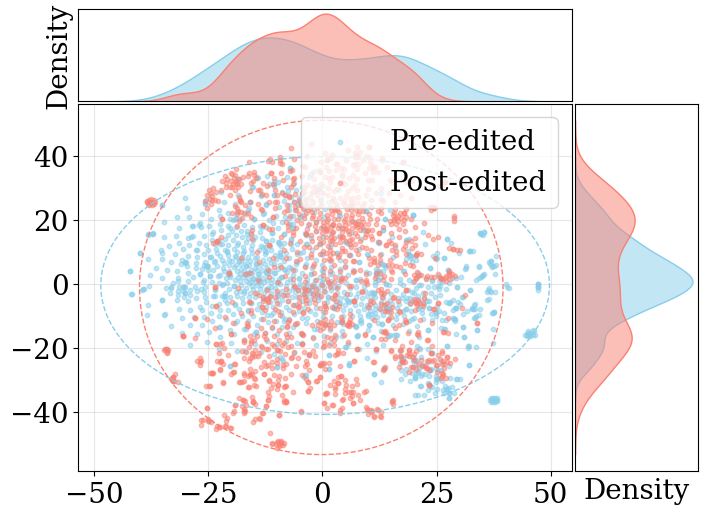

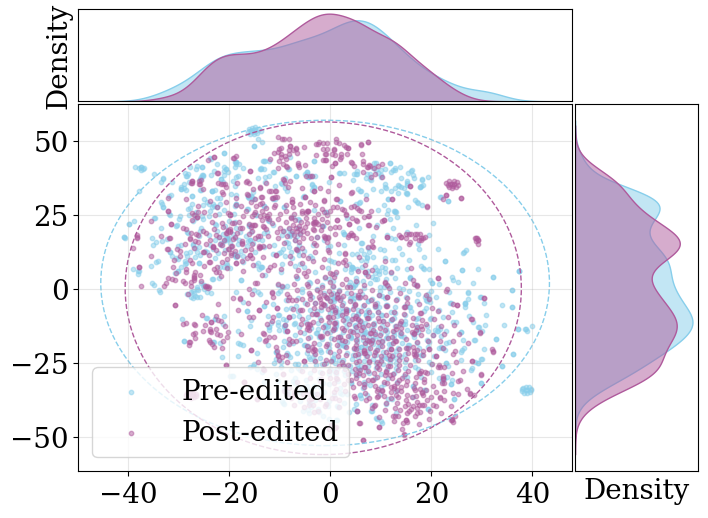

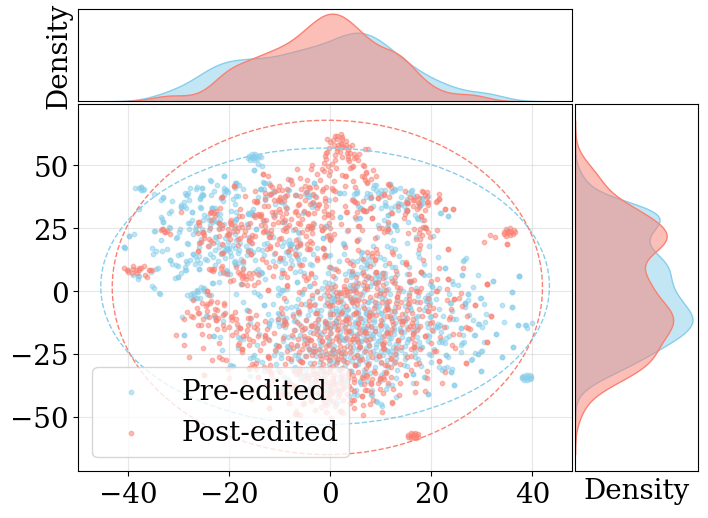

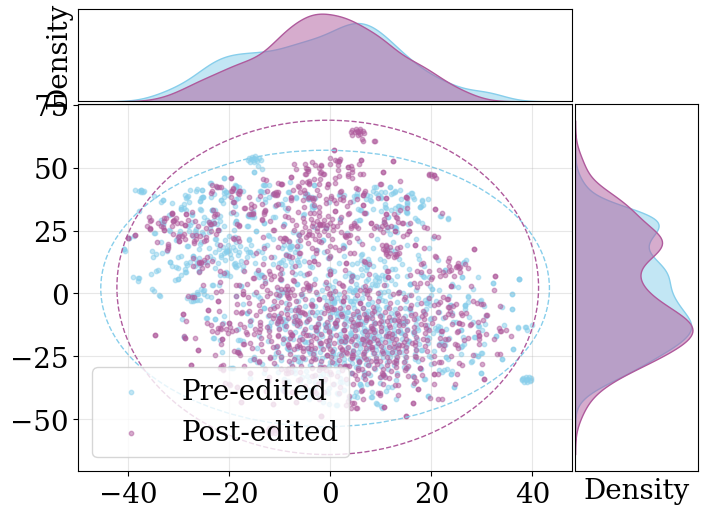

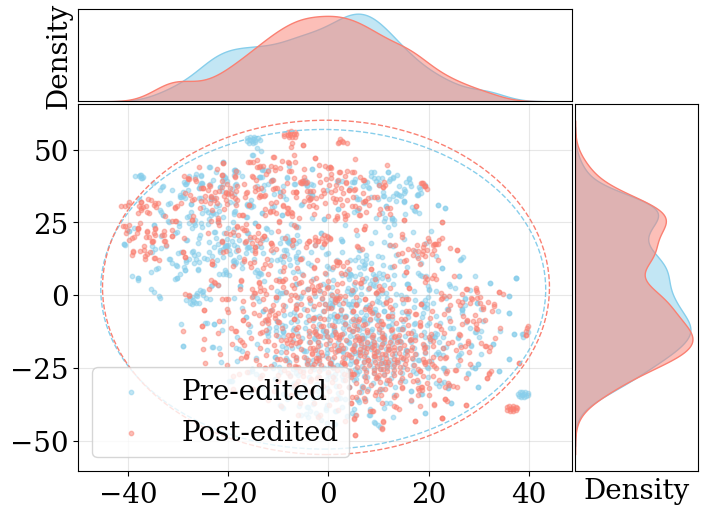

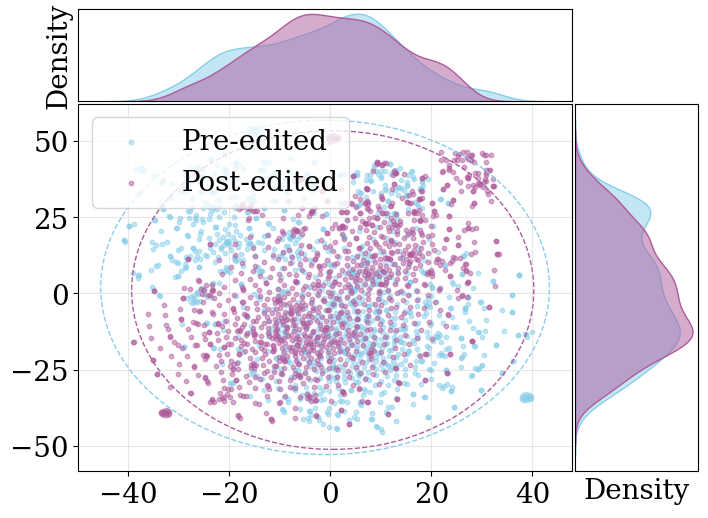

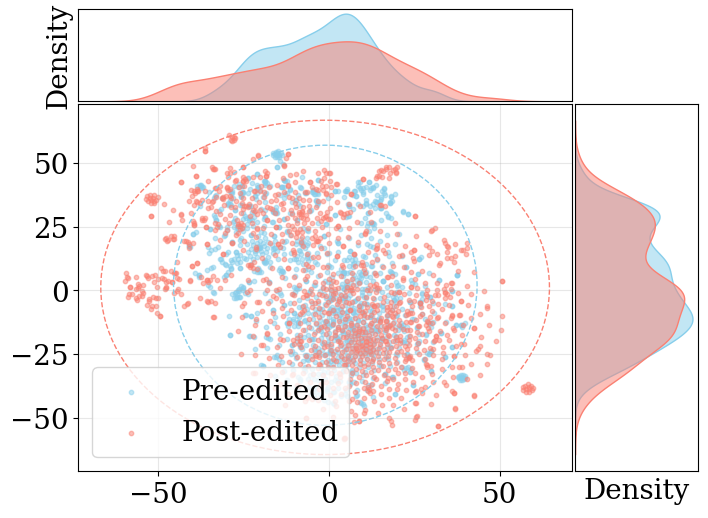

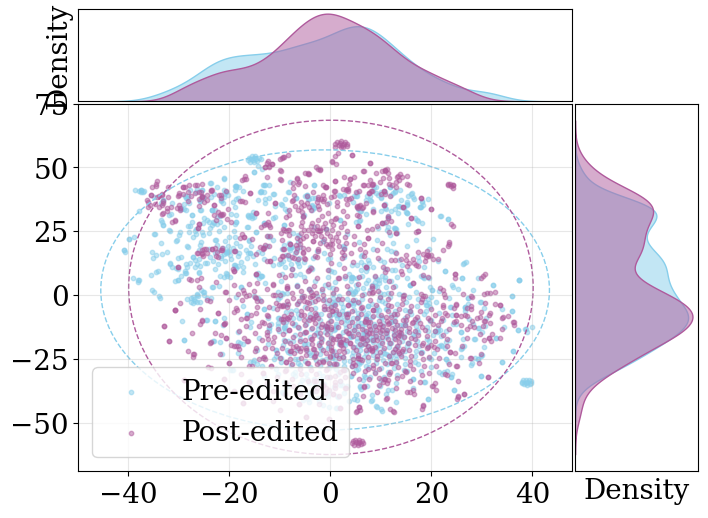

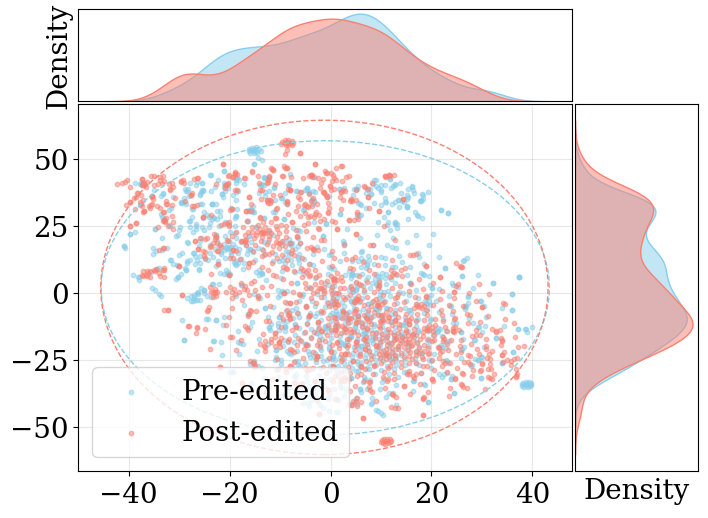

In [6]:
blues = [True, False]
llms = ["Meta-Llama-3-8B-Instruct", "EleutherAI_gpt-j-6B", "gpt2-xl"]
methods = ["MEMIT_prune", "MEMIT_rect", "AlphaEdit", "MEMIT_seq"]
for llm in llms:
    pre_hs = torch.load(f"./hs/pre_edit_hs_{llm}.pt")
    x_pre, y_pre = tsne_data(pre_hs.cpu().numpy())
    for method in methods:
        for blue in blues:
            if blue:
                post_hs = torch.load(f"./hs/post_seq_100_edit_hs_{method}_blue_{llm}_zsre.pt")
                x_post, y_post = tsne_data(post_hs.cpu().numpy())
                # 创建图形

                fig = create_scatter_density_plot(x_pre, y_pre, x_post, y_post, '#AF5A9C')
                plt.savefig(f"./figs/{method}_blue_{llm}.pdf")
            else:
                post_hs = torch.load(f"./hs/post_seq_100_edit_hs_{method}__{llm}_zsre.pt")
                x_post, y_post = tsne_data(post_hs.cpu().numpy())
                # 创建图形

                fig = create_scatter_density_plot(x_pre, y_pre, x_post, y_post)
                plt.savefig(f"./figs/{method}_{llm}.pdf")